# TSMixer: Time-Series Mixer (NeuralForecast)

## Entrenamiento en Dos Fases con Backtesting Rolling

---

**TSMixer** es un modelo de arquitectura **all-MLP** desarrollado por Google Research.

### Configuracion

| Parametro | Valor |
|-----------|-------|
| **Horizonte** | 24 horas (1 dia) |
| **Input size** | 168 horas (1 semana) |
| **Validacion** | 24 horas (1 dia) |
| **Test (backtesting)** | 72 horas (3 dias rolling) |
| **Libreria** | NeuralForecast (Nixtla) |

### Metodologia (Dos Fases)

1. **Fase 1**: Entrenar con todos los datos EXCEPTO ultimas 96 horas (24 val + 72 test)
   - Validar con las siguientes 24 horas
2. **Fase 2**: Agregar datos de validacion y continuar entrenamiento
   - Entrenar con todos los datos EXCEPTO ultimas 72 horas
3. **Evaluacion**: Backtesting rolling cada 24 horas sobre las ultimas 72 horas (3 dias)
   - Cada prediccion recibe el input actualizado hasta ese momento

---

In [158]:
import warnings
warnings.filterwarnings("ignore")

import logging
logging.getLogger('pytorch_lightning').setLevel(logging.ERROR)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import os
import sys
from datetime import datetime

# NeuralForecast
from neuralforecast import NeuralForecast
from neuralforecast.models import TSMixer
from neuralforecast.losses.pytorch import MAE, MSE

# Configuración de PyTorch
torch.set_float32_matmul_precision('high')

# Agregar el directorio raíz al path
sys.path.insert(0, os.path.abspath('..'))

print("="*60)
print("LIBRERÍAS CARGADAS")
print("="*60)
print(f"PyTorch: {torch.__version__}")
print(f"CUDA disponible: {torch.cuda.is_available()}")

LIBRERÍAS CARGADAS
PyTorch: 2.10.0+cpu
CUDA disponible: False


## Carga de Datos

In [159]:
# =============================================================================
# CARGAR Y PREPARAR DATOS (FORMATO NIXTLA)
# =============================================================================

# Cargar datos
df_raw = pd.read_parquet(os.path.join('..', 'data', 'Test_i', 'traindataset.parquet'))

# Seleccionar columnas relevantes
df_raw = df_raw[['datetime', 'CMg']].copy()

# Eliminar filas con datetime nulo
df_raw = df_raw.dropna(subset=['datetime']).reset_index(drop=True)

# Filtrar desde 2023
df_raw = df_raw[df_raw['datetime'] >= datetime(2023, 1, 1)].reset_index(drop=True)

# Formato NeuralForecast: unique_id, ds, y
df = pd.DataFrame({
    'unique_id': 'CMg',  # Identificador de la serie
    'ds': pd.to_datetime(df_raw['datetime']),
    'y': df_raw['CMg'].values
})

# Eliminar duplicados
df = df.drop_duplicates(subset=['unique_id', 'ds']).reset_index(drop=True)

print("="*60)
print("DATOS EN FORMATO NIXTLA")
print("="*60)
print(f"Columnas: {df.columns.tolist()}")
print(f"Registros: {len(df)}")
print(f"Rango: {df['ds'].min()} a {df['ds'].max()}")
print(f"Series únicas: {df['unique_id'].nunique()}")
df.head(10)

DATOS EN FORMATO NIXTLA
Columnas: ['unique_id', 'ds', 'y']
Registros: 22703
Rango: 2023-01-01 00:00:00 a 2025-08-04 00:00:00
Series únicas: 1


,unique_id,ds,y
0,CMg,2023-01-01 00:00:00,225.17
1,CMg,2023-01-01 01:00:00,171.56
2,CMg,2023-01-01 02:00:00,171.56
3,CMg,2023-01-01 03:00:00,164.95
4,CMg,2023-01-01 04:00:00,145.12
5,CMg,2023-01-01 05:00:00,145.12
6,CMg,2023-01-01 06:00:00,139.69
7,CMg,2023-01-01 07:00:00,84.82
8,CMg,2023-01-01 08:00:00,0.00
9,CMg,2023-01-01 09:00:00,0.00


In [160]:
# =============================================================================
# CONFIGURACION
# =============================================================================

# Hiperparametros del modelo
HORIZON = 24            # Horizonte de prediccion: 24 horas (1 dia)
INPUT_SIZE = 168        # Ventana de entrada: 168 horas (1 semana)

# Configuracion de validacion y test
VAL_HOURS = 24          # 24 horas para validacion (1 dia)
TEST_HOURS = 72         # 72 horas para test/backtesting (3 dias)
TEST_DAYS = TEST_HOURS // 24  # 3 dias

# Total de horas reservadas (validacion + test)
RESERVED_HOURS = VAL_HOURS + TEST_HOURS  # 96 horas total

# Calculos de indices
n_time = len(df)
phase1_train_end = n_time - RESERVED_HOURS     # Fin de datos para Fase 1
phase2_train_end = n_time - TEST_HOURS         # Fin de datos para Fase 2 (incluye validacion)
backtest_start_idx = phase2_train_end          # Inicio del backtesting

print("="*60)
print("CONFIGURACION - ENTRENAMIENTO EN DOS FASES")
print("="*60)
print(f"Total observaciones:  {n_time}")
print(f"Horizonte (h):        {HORIZON} horas (1 dia)")
print(f"Input size:           {INPUT_SIZE} horas ({INPUT_SIZE//24} dias)")
print("-"*60)
print(f"Validacion:           {VAL_HOURS} horas ({VAL_HOURS//24} dia)")
print(f"Test (backtesting):   {TEST_HOURS} horas ({TEST_DAYS} dias)")
print(f"Total reservado:      {RESERVED_HOURS} horas")
print("-"*60)
print("FASE 1 - Entrenamiento inicial:")
print(f"  Train:              {phase1_train_end} horas (hasta {df['ds'].iloc[phase1_train_end-1]})")
print(f"  Validacion:         {VAL_HOURS} horas ({df['ds'].iloc[phase1_train_end]} a {df['ds'].iloc[phase2_train_end-1]})")
print("-"*60)
print("FASE 2 - Entrenamiento con validacion:")
print(f"  Train:              {phase2_train_end} horas (hasta {df['ds'].iloc[phase2_train_end-1]})")
print("-"*60)
print("EVALUACION - Backtesting rolling:")
print(f"  Inicio:             {df['ds'].iloc[backtest_start_idx]}")
print(f"  Fin:                {df['ds'].iloc[-1]}")
print(f"  Predicciones:       {TEST_DAYS} dias de 24 horas cada uno")
print("  Input rolling:      Cada prediccion usa datos hasta ese momento")

CONFIGURACION - ENTRENAMIENTO EN DOS FASES
Total observaciones:  22703
Horizonte (h):        24 horas (1 dia)
Input size:           168 horas (7 dias)
------------------------------------------------------------
Validacion:           24 horas (1 dia)
Test (backtesting):   72 horas (3 dias)
Total reservado:      96 horas
------------------------------------------------------------
FASE 1 - Entrenamiento inicial:
  Train:              22607 horas (hasta 2025-07-30 22:00:00)
  Validacion:         24 horas (2025-07-30 23:00:00 a 2025-07-31 22:00:00)
------------------------------------------------------------
FASE 2 - Entrenamiento con validacion:
  Train:              22631 horas (hasta 2025-07-31 22:00:00)
------------------------------------------------------------
EVALUACION - Backtesting rolling:
  Inicio:             2025-07-31 23:00:00
  Fin:                2025-08-04 00:00:00
  Predicciones:       3 dias de 24 horas cada uno
  Input rolling:      Cada prediccion usa datos hasta ese

## Visualización de Datos

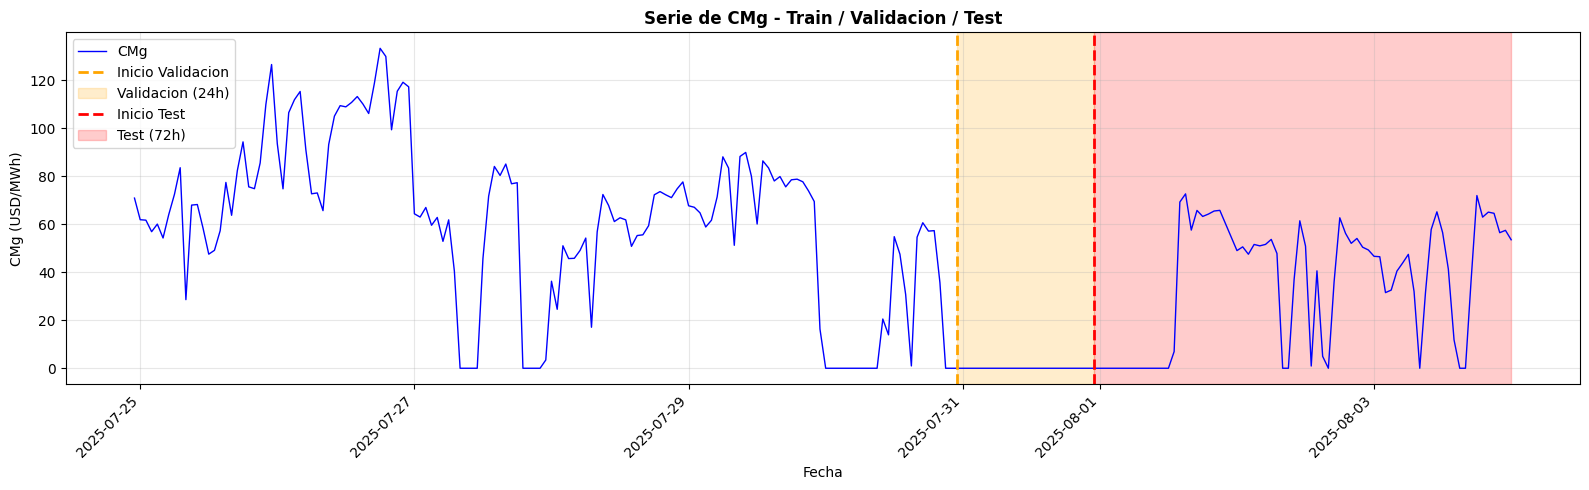

In [161]:
# =============================================================================
# VISUALIZACION - TRAIN / VALIDACION / TEST
# =============================================================================

fig, ax = plt.subplots(figsize=(16, 5), dpi=100)

# Ultimos 10 dias (suficiente para ver val + test)
plot_hours = 24 * 10
df_plot = df[-plot_hours:]

ax.plot(df_plot['ds'], df_plot['y'], 'b-', linewidth=1, label='CMg')

# Marcar zonas
val_start = df['ds'].iloc[phase1_train_end]
test_start = df['ds'].iloc[phase2_train_end]
test_end = df['ds'].iloc[-1]

# Zona de validacion (24 horas)
ax.axvline(x=val_start, color='orange', linestyle='--', linewidth=2, label='Inicio Validacion')
ax.axvspan(val_start, test_start, alpha=0.2, color='orange', label=f'Validacion ({VAL_HOURS}h)')

# Zona de test (72 horas)
ax.axvline(x=test_start, color='red', linestyle='--', linewidth=2, label='Inicio Test')
ax.axvspan(test_start, test_end, alpha=0.2, color='red', label=f'Test ({TEST_HOURS}h)')

ax.set_xlabel('Fecha')
ax.set_ylabel('CMg (USD/MWh)')
ax.set_title('Serie de CMg - Train / Validacion / Test', fontsize=12, fontweight='bold')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [162]:
# =============================================================================
# SEPARAR DATOS PARA ENTRENAMIENTO EN DOS FASES
# =============================================================================

# FASE 1: Entrenamiento inicial (sin validacion ni test)
df_train_phase1 = df[:phase1_train_end].copy()

# Datos de validacion (para referencia)
df_validation = df[phase1_train_end:phase2_train_end].copy()

# FASE 2: Entrenamiento con validacion incluida (sin test)
df_train_phase2 = df[:phase2_train_end].copy()

# Datos de test (para backtesting rolling)
df_test = df[phase2_train_end:].copy()

print("="*60)
print("DATOS SEPARADOS PARA ENTRENAMIENTO EN DOS FASES")
print("="*60)
print("\nFASE 1 - Entrenamiento inicial:")
print(f"  Train Phase 1:  {len(df_train_phase1)} obs")
print(f"  Desde:          {df_train_phase1['ds'].min()}")
print(f"  Hasta:          {df_train_phase1['ds'].max()}")
print(f"\n  Validacion:     {len(df_validation)} obs ({VAL_HOURS} horas)")
print(f"  Desde:          {df_validation['ds'].min()}")
print(f"  Hasta:          {df_validation['ds'].max()}")
print("-"*60)
print("\nFASE 2 - Entrenamiento con validacion:")
print(f"  Train Phase 2:  {len(df_train_phase2)} obs")
print(f"  Desde:          {df_train_phase2['ds'].min()}")
print(f"  Hasta:          {df_train_phase2['ds'].max()}")
print("-"*60)
print("\nTEST - Backtesting rolling:")
print(f"  Test:           {len(df_test)} obs ({TEST_HOURS} horas = {TEST_DAYS} dias)")
print(f"  Desde:          {df_test['ds'].min()}")
print(f"  Hasta:          {df_test['ds'].max()}")
print()
print("NOTA: En backtesting, cada prediccion recibe input actualizado")

DATOS SEPARADOS PARA ENTRENAMIENTO EN DOS FASES

FASE 1 - Entrenamiento inicial:
  Train Phase 1:  22607 obs
  Desde:          2023-01-01 00:00:00
  Hasta:          2025-07-30 22:00:00

  Validacion:     24 obs (24 horas)
  Desde:          2025-07-30 23:00:00
  Hasta:          2025-07-31 22:00:00
------------------------------------------------------------

FASE 2 - Entrenamiento con validacion:
  Train Phase 2:  22631 obs
  Desde:          2023-01-01 00:00:00
  Hasta:          2025-07-31 22:00:00
------------------------------------------------------------

TEST - Backtesting rolling:
  Test:           72 obs (72 horas = 3 dias)
  Desde:          2025-07-31 23:00:00
  Hasta:          2025-08-04 00:00:00

NOTA: En backtesting, cada prediccion recibe input actualizado


## Modelo TSMixer (NeuralForecast) - Fase 1

**Fase 1**: Entrenamiento inicial con validacion en las siguientes 24 horas

In [163]:
# =============================================================================
# CONFIGURAR MODELO TSMIXER - FASE 1
# =============================================================================

model_tsmixer_phase1 = TSMixer(
    h=HORIZON,                      # Horizonte: 24 horas (1 dia)
    input_size=INPUT_SIZE,          # Ventana entrada: 168 horas (1 semana)
    n_series=1,                     # Univariado (1 serie)
    max_steps=2000,                 # Pasos de entrenamiento
    val_check_steps=50,             # Validar cada 50 pasos
    early_stop_patience_steps=5,    # Early stopping
    scaler_type='standard',         # Normalizacion estandar
    learning_rate=1e-3,             # Learning rate
    batch_size=32,                  # Batch size
    valid_loss=MAE(),               # Loss de validacion
    random_seed=42,
)

print("="*60)
print("MODELO TSMIXER - FASE 1 CONFIGURADO")
print("="*60)
print(f"Horizonte (h):    {HORIZON} horas (1 dia)")
print(f"Input size:       {INPUT_SIZE} horas ({INPUT_SIZE//24} dias)")
print(f"n_series:         1 (univariado)")
print(f"Max steps:        1000")
print(f"Early stopping:   5 pasos sin mejora")

MODELO TSMIXER - FASE 1 CONFIGURADO
Horizonte (h):    24 horas (1 dia)
Input size:       168 horas (7 dias)
n_series:         1 (univariado)
Max steps:        1000
Early stopping:   5 pasos sin mejora


In [164]:
# =============================================================================
# CREAR NEURALFORECAST - FASE 1
# =============================================================================

nf_phase1 = NeuralForecast(
    models=[model_tsmixer_phase1],
    freq='h'  # Frecuencia horaria
)

print("NeuralForecast FASE 1 inicializado con TSMixer")

NeuralForecast FASE 1 inicializado con TSMixer


## Entrenamiento Fase 1

Entrenar con datos hasta 96 horas antes del final, validando con las siguientes 24 horas.

In [165]:
# =============================================================================
# ENTRENAMIENTO FASE 1
# =============================================================================
print("="*60)
print("FASE 1: ENTRENAMIENTO INICIAL")
print("="*60)
print(f"Train: {len(df_train_phase1)} obs (hasta {df_train_phase1['ds'].max()})")
print(f"Validacion interna: {VAL_HOURS} horas")
print()
print("Iniciando entrenamiento FASE 1...")
print("(Esto puede tomar varios minutos en CPU)")
print()

# Entrenar con datos de fase 1, usando VAL_HOURS para validacion interna
nf_phase1.fit(df=df_train_phase1, val_size=VAL_HOURS)

print("\n" + "="*60)
print("FASE 1 COMPLETADA")
print("="*60)

# Evaluar en datos de validacion (24 horas reales, no vistas)
forecast_val = nf_phase1.predict(df=df_train_phase1)

# Comparar con datos reales de validacion
val_predictions = forecast_val['TSMixer'].values[:VAL_HOURS]
val_real = df_validation['y'].values[:len(val_predictions)]

mae_val = np.mean(np.abs(val_real - val_predictions))
rmse_val = np.sqrt(np.mean((val_real - val_predictions)**2))

print(f"\nRendimiento en Validacion ({VAL_HOURS} horas):")
print(f"  MAE:  {mae_val:.2f} USD/MWh")
print(f"  RMSE: {rmse_val:.2f} USD/MWh")

FASE 1: ENTRENAMIENTO INICIAL
Train: 22607 obs (hasta 2025-07-30 22:00:00)
Validacion interna: 24 horas

Iniciando entrenamiento FASE 1...
(Esto puede tomar varios minutos en CPU)



Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


FASE 1 COMPLETADA


Predicting: |          | 0/? [00:00<?, ?it/s]


Rendimiento en Validacion (24 horas):
  MAE:  42.00 USD/MWh
  RMSE: 43.67 USD/MWh


---

## Fase 2: Entrenamiento con Datos de Validacion

Agregar las 24 horas de validacion al entrenamiento y re-entrenar el modelo.

In [166]:
# =============================================================================
# CONFIGURAR MODELO TSMIXER - FASE 2
# =============================================================================

model_tsmixer_phase2 = TSMixer(
    h=HORIZON,                      # Horizonte: 24 horas (1 dia)
    input_size=INPUT_SIZE,          # Ventana entrada: 168 horas (1 semana)
    n_series=1,                     # Univariado (1 serie)
    max_steps=1000,                 # Pasos de entrenamiento
    val_check_steps=50,             # Validar cada 50 pasos
    early_stop_patience_steps=5,    # Early stopping
    scaler_type='standard',         # Normalizacion estandar
    learning_rate=1e-3,             # Learning rate
    batch_size=32,                  # Batch size
    valid_loss=MAE(),               # Loss de validacion
    random_seed=42,
)

nf_phase2 = NeuralForecast(
    models=[model_tsmixer_phase2],
    freq='h'
)

print("="*60)
print("FASE 2: ENTRENAMIENTO CON DATOS DE VALIDACION")
print("="*60)
print(f"Train Phase 2: {len(df_train_phase2)} obs")
print(f"Incluye:       Datos originales + {VAL_HOURS} horas de validacion")
print(f"Hasta:         {df_train_phase2['ds'].max()}")
print()
print("Iniciando entrenamiento FASE 2...")
print()

# Entrenar con todos los datos hasta el test (incluye validacion)
# Usar un pequeno conjunto de validacion interno para early stopping
nf_phase2.fit(df=df_train_phase2, val_size=VAL_HOURS)

print("\n" + "="*60)
print("FASE 2 COMPLETADA")
print("="*60)
print(f"Modelo listo para backtesting en las ultimas {TEST_HOURS} horas")

FASE 2: ENTRENAMIENTO CON DATOS DE VALIDACION
Train Phase 2: 22631 obs
Incluye:       Datos originales + 24 horas de validacion
Hasta:         2025-07-31 22:00:00

Iniciando entrenamiento FASE 2...



Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


FASE 2 COMPLETADA
Modelo listo para backtesting en las ultimas 72 horas


In [167]:
# =============================================================================
# BACKTESTING ROLLING - TEST (72 HORAS = 3 DIAS)
# =============================================================================
from tqdm import tqdm

print("="*60)
print("BACKTESTING ROLLING - TEST FINAL")
print("="*60)
print(f"Periodo:            {TEST_DAYS} dias ({TEST_HOURS} horas)")
print(f"Prediccion diaria:  {HORIZON} horas")
print(f"Input por pred:     {INPUT_SIZE} horas ({INPUT_SIZE//24} dias)")
print(f"Total predicciones: {TEST_DAYS} (una por dia)")
print(f"Inicio test:        {df['ds'].iloc[backtest_start_idx]}")
print(f"Fin test:           {df['ds'].iloc[-1]}")
print()
print("ROLLING: Cada prediccion recibe datos actualizados hasta ese momento")
print()
print("Ejecutando backtesting rolling...")
print()

# Lista para almacenar todas las predicciones
all_predictions = []

# Loop por cada dia del periodo de test
for day in tqdm(range(TEST_DAYS), desc="Backtesting"):
    # Calcular indices
    # pred_start_idx es el indice donde comienza la prediccion de 24h
    pred_start_idx = backtest_start_idx + (day * HORIZON)
    pred_end_idx = pred_start_idx + HORIZON
    
    # IMPORTANTE: Datos hasta justo antes de la prediccion
    # El modelo recibe todo el historico hasta pred_start_idx (exclusivo)
    # Esto simula el escenario real donde predecimos las proximas 24h
    df_input_rolling = df[:pred_start_idx].copy()
    
    # Info del dia
    input_end_time = df_input_rolling['ds'].iloc[-1]
    pred_start_time = df['ds'].iloc[pred_start_idx]
    
    if day == 0:
        print(f"\nDia {day+1}:")
        print(f"  Input hasta:     {input_end_time}")
        print(f"  Predice desde:   {pred_start_time}")
        print(f"  Predice hasta:   {df['ds'].iloc[pred_end_idx-1]}")
    
    # Hacer prediccion usando el modelo de fase 2
    # El modelo usa las ultimas INPUT_SIZE horas de df_input_rolling como input
    forecast_day = nf_phase2.predict(df=df_input_rolling)
    
    # Guardar predicciones con datos reales
    for h in range(HORIZON):
        if pred_start_idx + h < len(df):
            all_predictions.append({
                'ds': df['ds'].iloc[pred_start_idx + h],
                'y_real': df['y'].iloc[pred_start_idx + h],
                'y_pred': forecast_day['TSMixer'].iloc[h],
                'dia_backtest': day + 1,
                'hora_prediccion': h + 1,
                'input_hasta': input_end_time
            })

# Crear DataFrame con resultados
df_backtest = pd.DataFrame(all_predictions)
df_backtest['error'] = df_backtest['y_real'] - df_backtest['y_pred']
df_backtest['error_abs'] = df_backtest['error'].abs()

print("\n" + "="*60)
print("BACKTESTING COMPLETADO")
print("="*60)
print(f"Total predicciones: {len(df_backtest)} horas")
print(f"Dias evaluados: {df_backtest['dia_backtest'].nunique()}")
print()
print("Detalle por dia:")
for day in range(1, TEST_DAYS + 1):
    day_data = df_backtest[df_backtest['dia_backtest'] == day]
    print(f"  Dia {day}: Input hasta {day_data['input_hasta'].iloc[0]} -> Predice {day_data['ds'].min()} a {day_data['ds'].max()}")

BACKTESTING ROLLING - TEST FINAL
Periodo:            3 dias (72 horas)
Prediccion diaria:  24 horas
Input por pred:     168 horas (7 dias)
Total predicciones: 3 (una por dia)
Inicio test:        2025-07-31 23:00:00
Fin test:           2025-08-04 00:00:00

ROLLING: Cada prediccion recibe datos actualizados hasta ese momento

Ejecutando backtesting rolling...



Backtesting:   0%|          | 0/3 [00:00<?, ?it/s]


Dia 1:
  Input hasta:     2025-07-31 22:00:00
  Predice desde:   2025-07-31 23:00:00
  Predice hasta:   2025-08-02 00:00:00


Predicting: |          | 0/? [00:00<?, ?it/s]

Backtesting:  33%|███▎      | 1/3 [00:00<00:00,  6.61it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Backtesting:  67%|██████▋   | 2/3 [00:00<00:00,  6.66it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Backtesting: 100%|██████████| 3/3 [00:00<00:00,  6.88it/s]


BACKTESTING COMPLETADO
Total predicciones: 72 horas
Dias evaluados: 3

Detalle por dia:
  Dia 1: Input hasta 2025-07-31 22:00:00 -> Predice 2025-07-31 23:00:00 a 2025-08-02 00:00:00
  Dia 2: Input hasta 2025-08-02 00:00:00 -> Predice 2025-08-02 01:00:00 a 2025-08-03 00:00:00
  Dia 3: Input hasta 2025-08-03 00:00:00 -> Predice 2025-08-03 01:00:00 a 2025-08-04 00:00:00


In [168]:
# =============================================================================
# METRICAS DEL BACKTESTING - TEST FINAL
# =============================================================================

# Metricas globales
mae_backtest = df_backtest['error_abs'].mean()
rmse_backtest = np.sqrt((df_backtest['error']**2).mean())
mask_bt = df_backtest['y_real'] != 0
mape_backtest = np.mean(np.abs(df_backtest.loc[mask_bt, 'error'] / df_backtest.loc[mask_bt, 'y_real'])) * 100

print("="*60)
print(f"METRICAS GLOBALES - TEST {TEST_DAYS} DIAS ({TEST_HOURS} HORAS)")
print("="*60)
print(f"MAE:  {mae_backtest:.2f} USD/MWh")
print(f"RMSE: {rmse_backtest:.2f} USD/MWh")
print(f"MAPE: {mape_backtest:.2f}%")

# Metricas por hora de prediccion
metricas_por_hora = df_backtest.groupby('hora_prediccion').agg({
    'error_abs': 'mean',
    'error': ['mean', 'std']
}).round(2)
metricas_por_hora.columns = ['MAE', 'Error_Medio', 'Error_Std']

print("\n" + "="*60)
print("MAE POR HORA DE PREDICCION (promedio de los 3 dias)")
print("="*60)
print(metricas_por_hora.to_string())

# Metricas por dia
metricas_por_dia = df_backtest.groupby('dia_backtest').agg({
    'error_abs': 'mean',
    'y_real': 'mean',
    'y_pred': 'mean'
}).round(2)
metricas_por_dia.columns = ['MAE_Diario', 'Real_Promedio', 'Pred_Promedio']

print("\n" + "="*60)
print("MAE POR DIA DE TEST")
print("="*60)
print(metricas_por_dia.to_string())

METRICAS GLOBALES - TEST 3 DIAS (72 HORAS)
MAE:  17.34 USD/MWh
RMSE: 20.68 USD/MWh
MAPE: 115.43%

MAE POR HORA DE PREDICCION (promedio de los 3 dias)
                   MAE  Error_Medio  Error_Std
hora_prediccion                               
1                 1.19        -0.41       1.81
2                 6.97        -4.16       7.93
3                 8.13         1.23      11.13
4                 8.67         0.89      12.61
5                10.52         1.04      14.21
6                16.99         7.00      19.69
7                13.13         3.53      17.46
8                19.67       -19.67       7.70
9                12.98        -6.83      15.79
10               20.84        11.38      23.60
11               28.21        15.93      29.76
12               20.79         8.43      23.42
13               21.13       -12.38      22.94
14               14.36       -14.27      12.86
15               31.64       -31.64       6.99
16               42.10       -16.11      48.07
17  

## Grafico Interactivo - Backtesting Rolling (Test Final)

In [169]:
# =============================================================================
# GRAFICO INTERACTIVO - PREDICCIONES VS REAL
# =============================================================================
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Crear figura con subplots
fig = make_subplots(
    rows=3, cols=1,
    subplot_titles=(
        f'Predicciones Rolling vs Valores Reales ({TEST_DAYS} dias)',
        'Error de Prediccion por Hora',
        'MAE Diario durante el Test'
    ),
    vertical_spacing=0.08,
    row_heights=[0.45, 0.30, 0.25]
)

# --- Subplot 1: Predicciones vs Real ---
fig.add_trace(
    go.Scatter(
        x=df_backtest['ds'],
        y=df_backtest['y_real'],
        mode='lines',
        name='Real',
        line=dict(color='green', width=1.5),
        hovertemplate='<b>Fecha:</b> %{x}<br><b>Real:</b> %{y:.2f} USD/MWh<extra></extra>'
    ),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(
        x=df_backtest['ds'],
        y=df_backtest['y_pred'],
        mode='lines',
        name='Prediccion TSMixer',
        line=dict(color='red', width=1.5, dash='dot'),
        opacity=0.8,
        hovertemplate='<b>Fecha:</b> %{x}<br><b>Prediccion:</b> %{y:.2f} USD/MWh<extra></extra>'
    ),
    row=1, col=1
)

# --- Subplot 2: Error por hora ---
fig.add_trace(
    go.Scatter(
        x=df_backtest['ds'],
        y=df_backtest['error'],
        mode='lines',
        name='Error',
        line=dict(color='purple', width=1),
        fill='tozeroy',
        fillcolor='rgba(128, 0, 128, 0.2)',
        hovertemplate='<b>Fecha:</b> %{x}<br><b>Error:</b> %{y:.2f} USD/MWh<extra></extra>'
    ),
    row=2, col=1
)

# Lineas de MAE
fig.add_hline(y=mae_backtest, line_dash="dash", line_color="red", 
              annotation_text=f"MAE: {mae_backtest:.2f}", row=2, col=1)
fig.add_hline(y=-mae_backtest, line_dash="dash", line_color="red", row=2, col=1)
fig.add_hline(y=0, line_color="black", line_width=0.5, row=2, col=1)

# --- Subplot 3: MAE Diario ---
mae_diario = df_backtest.groupby(df_backtest['ds'].dt.date)['error_abs'].mean().reset_index()
mae_diario.columns = ['fecha', 'mae']

fig.add_trace(
    go.Bar(
        x=mae_diario['fecha'],
        y=mae_diario['mae'],
        name='MAE Diario',
        marker_color='steelblue',
        hovertemplate='<b>Fecha:</b> %{x}<br><b>MAE:</b> %{y:.2f} USD/MWh<extra></extra>'
    ),
    row=3, col=1
)

# Linea de MAE promedio
fig.add_hline(y=mae_backtest, line_dash="dash", line_color="red",
              annotation_text=f"MAE Promedio: {mae_backtest:.2f}", row=3, col=1)

# Layout
fig.update_layout(
    height=900,
    title=dict(
        text=f'<b>TSMixer - Test Rolling {TEST_DAYS} Dias (Dos Fases)</b><br><sup>MAE: {mae_backtest:.2f} | RMSE: {rmse_backtest:.2f} | MAPE: {mape_backtest:.2f}%</sup>',
        x=0.5,
        font=dict(size=16)
    ),
    showlegend=True,
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    ),
    hovermode='x unified'
)

# Etiquetas de ejes
fig.update_yaxes(title_text="CMg (USD/MWh)", row=1, col=1)
fig.update_yaxes(title_text="Error (USD/MWh)", row=2, col=1)
fig.update_yaxes(title_text="MAE (USD/MWh)", row=3, col=1)
fig.update_xaxes(title_text="Fecha", row=3, col=1)

# Mostrar
fig.show()

In [170]:
# =============================================================================
# GRAFICO INTERACTIVO - MAE POR HORA DE PREDICCION
# =============================================================================

# MAE por hora de prediccion
mae_por_hora = df_backtest.groupby('hora_prediccion')['error_abs'].mean().reset_index()
mae_por_hora.columns = ['hora', 'mae']

fig2 = go.Figure()

fig2.add_trace(
    go.Bar(
        x=mae_por_hora['hora'],
        y=mae_por_hora['mae'],
        marker_color=['steelblue' if m <= mae_backtest else 'coral' for m in mae_por_hora['mae']],
        hovertemplate='<b>Hora %{x}</b><br>MAE: %{y:.2f} USD/MWh<extra></extra>'
    )
)

fig2.add_hline(y=mae_backtest, line_dash="dash", line_color="red",
               annotation_text=f"MAE Promedio: {mae_backtest:.2f}")

fig2.update_layout(
    title=dict(
        text=f'<b>MAE por Hora de Prediccion (Test {TEST_DAYS} dias)</b><br><sup>Como aumenta el error segun el horizonte de prediccion</sup>',
        x=0.5
    ),
    xaxis_title='Hora de Prediccion (1-24)',
    yaxis_title='MAE (USD/MWh)',
    height=400,
    showlegend=False
)

fig2.update_xaxes(tickmode='linear', tick0=1, dtick=1)

fig2.show()

In [171]:
# =============================================================================
# GUARDAR RESULTADOS DEL TEST
# =============================================================================

# Crear directorio si no existe
os.makedirs('../models', exist_ok=True)

# Guardar DataFrame completo del backtesting
backtest_path = f'../models/tsmixer_test_{TEST_DAYS}days.csv'
df_backtest.to_csv(backtest_path, index=False)
print(f"Resultados test guardados en: {backtest_path}")

# Guardar grafico interactivo como HTML
fig.write_html(f'../models/tsmixer_test_{TEST_DAYS}days_interactive.html')
print(f"Grafico interactivo guardado en: ../models/tsmixer_test_{TEST_DAYS}days_interactive.html")

# Guardar modelo (Fase 2 - modelo final)
model_path = '../models/tsmixer_24h_2phases_neuralforecast'
nf_phase2.save(path=model_path, overwrite=True)
print(f"Modelo (Fase 2) guardado en: {model_path}")

print("\n" + "="*60)
print("RESUMEN FINAL - ENTRENAMIENTO DOS FASES")
print("="*60)
print(f"Horizonte diario:    {HORIZON} horas")
print(f"Input size:          {INPUT_SIZE} horas ({INPUT_SIZE//24} dias)")
print("-"*60)
print(f"Validacion:          {VAL_HOURS} horas ({VAL_HOURS//24} dias)")
print(f"Test:                {TEST_HOURS} horas ({TEST_DAYS} dias)")
print("-"*60)
print(f"Total predicciones:  {len(df_backtest)} horas")
print("-"*60)
print("METRICAS TEST:")
print(f"  MAE:               {mae_backtest:.2f} USD/MWh")
print(f"  RMSE:              {rmse_backtest:.2f} USD/MWh")
print(f"  MAPE:              {mape_backtest:.2f}%")
print("="*60)

Resultados test guardados en: ../models/tsmixer_test_3days.csv
Grafico interactivo guardado en: ../models/tsmixer_test_3days_interactive.html
Modelo (Fase 2) guardado en: ../models/tsmixer_24h_2phases_neuralforecast

RESUMEN FINAL - ENTRENAMIENTO DOS FASES
Horizonte diario:    24 horas
Input size:          168 horas (7 dias)
------------------------------------------------------------
Validacion:          24 horas (1 dias)
Test:                72 horas (3 dias)
------------------------------------------------------------
Total predicciones:  72 horas
------------------------------------------------------------
METRICAS TEST:
  MAE:               17.34 USD/MWh
  RMSE:              20.68 USD/MWh
  MAPE:              115.43%
